In [6]:
import os
import urllib.request
import os
import urllib.request
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
os.sys.path.append('/Users/djuna/Documents/ABCA7lof2/')
from ABCA7lof2.lcms_funcs import return_stats, plot_volcano, plot_pca, count_unsaturations, count_carbons, plot_lfcs, plot_carbon_distributions, plot_class_counts, plot_with_blank, classify_fatty_acid_length, classify_unsaturation
# load libraries

output_dir = "../../LCMS/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

urls = ['https://storage.googleapis.com/abca7lof/LCMS/SUB14737/5041.SUB14737_LipidXData.csv']

for url in urls:
    local_filename = os.path.join(output_dir, os.path.basename(url))
    urllib.request.urlretrieve(url, local_filename)
    print("Download completed!")

Download completed!


In [7]:
# load libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests


In [9]:
# get metadata 
# Load data 
# load lipid key
output_dir = '../../../LCMS/'

key = pd.read_csv(os.path.join(output_dir, 'LipidKey.csv'))
dictionary = dict(zip(key['Key'], key['Class']))



# Load the Excel file
excel_file = os.path.join(output_dir, '8074.SUB14547_LididomicsData.xlsx')

# Load the sheet into a DataFrame
sheet_name = 'All lipids'  # Replace with the actual sheet name if different
meta = pd.read_excel(excel_file, sheet_name=sheet_name)

metadata = meta.iloc[5:24,49:]
metadata.columns = meta.iloc[3,49:]
dictionary_date = dict(zip(metadata['LS name'], metadata.iloc[:,2].astype(str)))
dictionary_grp = dict(zip(metadata['LS name'], metadata.iloc[:,3]))


/Users/djuna/Library/Python/3.9/lib/python/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


In [10]:
# load data
data = pd.read_csv(output_dir + '7257.SUB14547_LipidXdata.csv')

# get areas
areas = data[[col for col in data.columns if col.startswith('area[')]]
areas.index = data['name']
names = np.array([x.split('[')[1].split(']')[0] for x in areas.columns])
areas_columns = np.array([dictionary_grp[x] for x in names])
areas_dates = np.array([dictionary_date[x] for x in names])

areas_24 = areas.iloc[:,areas_dates=='2024-04-24 00:00:00']
names_24 = areas_columns[areas_dates=='2024-04-24 00:00:00']

In [11]:
palette = {
    'Sphingolipids':'#1DC9A4',
    'Neutral lipids':'#E3120B',
    'Phospholipids':'#475ED1',
    'Fatty acyl and other lipids':'#F97A1F', 
    'Neutral glycerolipid':'#E3120B',	
    'Steroid':'#F9C31F', 
    'Glycoglycerolipids':'blue'
}

key = pd.read_csv(os.path.join(output_dir, 'LipidKey.csv'))
dictionary = dict(zip(key['Key'], key['Class']))


In [17]:
# return stats for E3 vs G2
stats = return_stats(areas_24, names_24, 'E3 H2O', 'G2 H2O')

stats['name'] = stats.index
stats['grp'] = [dictionary[x.split('(')[0]] for x in stats.index]

# Drop rows where fold change is NaN
stats = stats.dropna(subset=['log2_fold_change'])

# correct pvalues
stats['fdr_corrected_p_value'] = multipletests(stats['p_value'], method='fdr_bh')[1]

# add class column
stats['class'] = [x.split('(')[0] for x in stats.index]

# add unsaturation and carbon length column 
stats['carbons'] = stats['name'].apply(count_carbons)
stats['unsaturations'] = stats['name'].apply(count_unsaturations)
stats['unsat_grp'] = [classify_unsaturation(count_unsaturations(x)) for x in stats.index]

# categorize species
stats['cat'] = 'other'
stats.loc[(stats['log2_fold_change']< -1) & (stats['fdr_corrected_p_value']<0.05), 'cat'] = 'down'
stats.loc[(stats['log2_fold_change']>1) & (stats['fdr_corrected_p_value']<0.05), 'cat'] = 'up'
stats['cat'] = stats['cat'].astype(str)


/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/lcms_funcs.py:33: RuntimeWarning: divide by zero encountered in log2
  log2_fold_change = np.log2(mean_group2 / mean_group1) if mean_group1 != 0 else np.inf


In [24]:
stats.sort_values(by='p_value')[:20]

,t_stat,p_value,log2_fold_change,fdr_corrected_p_value,name,grp,class,carbons,unsaturations,unsat_grp,cat,size
PC(17:1)+H_34.17,11.810772,0.000128,0.860282,0.028397,PC(17:1)+H_34.17,Phospholipids,PC,17,1,MUFA,other,10
MLCL(46:4)-2H_21.65,12.023704,0.000306,1.396201,0.031921,MLCL(46:4)-2H_21.65,Phospholipids,MLCL,46,4,PUFA,up,50
TG(20:4_10:2_14:4)+NH4_37.71,8.098754,0.000489,0.913805,0.031921,TG(20:4_10:2_14:4)+NH4_37.71,Neutral glycerolipid,TG,44,10,PUFA,other,10
PC(32:1)+HCOO_30.97,7.379620,0.000719,0.741905,0.031921,PC(32:1)+HCOO_30.97,Phospholipids,PC,32,1,MUFA,other,10
PS(35:0)-H_30.98,7.379620,0.000719,0.741905,0.031921,PS(35:0)-H_30.98,Phospholipids,PS,35,0,SFA,other,10
PE(36:3)+Li_37.67,7.030711,0.000901,0.797967,0.033334,PE(36:3)+Li_37.67,Phospholipids,PE,36,3,PUFA,other,10
TG(18:0_11:4_16:0)+K_42.32,6.858192,0.001180,0.801724,0.034272,TG(18:0_11:4_16:0)+K_42.32,Neutral glycerolipid,TG,45,4,PUFA,other,10
PC(18:0_16:0)+Na_44.75,6.788435,0.001277,0.718035,0.034272,PC(18:0_16:0)+Na_44.75,Phospholipids,PC,34,0,SFA,other,10
PS(34:0)-H_23.0,6.473317,0.001389,0.941763,0.034272,PS(34:0)-H_23.0,Phospholipids,PS,34,0,SFA,other,10
TG(18:4_10:3_18:3)+NH4_32.03,8.599039,0.002204,1.211501,0.048923,TG(18:4_10:3_18:3)+NH4_32.03,Neutral glycerolipid,TG,46,10,PUFA,up,50


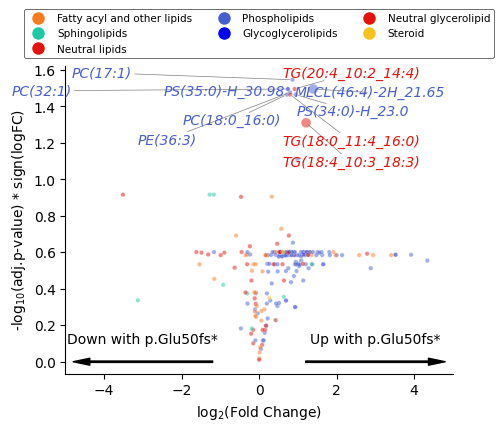

In [26]:
# plot volcano 
plot_volcano('fdr_corrected_p_value', 'name', 'grp', 'log2_fold_change', stats, palette, force_text=True)
plt.ylabel('-log$_{10}$(adj.p-value) * sign(logFC)')

plt.annotate('', xy=(5,0), xytext=(1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(3, .1, 'Up with p.Glu50fs*', ha='center', fontsize=10)

plt.annotate('', xy=(-5,0), xytext=(-1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(-3, .1, 'Down with p.Glu50fs*', ha='center', fontsize=10)

plt.xlim(-5,5)

labels = stats['grp'].unique()

handles = [
    Line2D([0], [0], marker='o', color='w', label=label,
           markerfacecolor=palette[label], markersize=10)
    for label in labels
]

legend = plt.legend(handles=handles, loc='upper center', bbox_to_anchor=(.5, 1.2), ncol=3, frameon=True, fontsize=7.5)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(.5)

/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


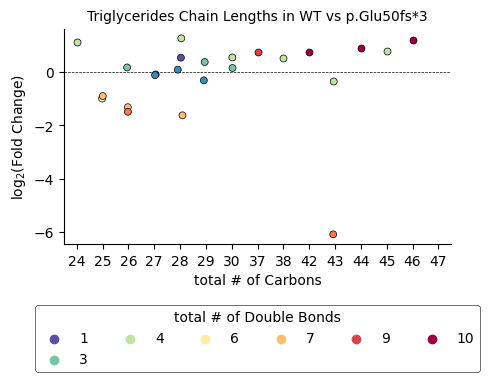

In [27]:
temp = stats[stats['class']=='TG'].copy()
temp['score'] = np.sign(temp['log2_fold_change']) * -np.log10(temp['fdr_corrected_p_value'])
plt.figure(figsize=(5, 2.8))
#
sp = sns.stripplot(data=temp, x='carbons', y='log2_fold_change', jitter=0.1, alpha = 1, hue = 'unsaturations', color = 'black', palette = 'Spectral_r', edgecolor='black', linewidth=0.5)

sp.spines['top'].set_visible(False)
sp.spines['right'].set_visible(False)

legend = plt.legend(bbox_to_anchor=(0.5, -0.25), loc='upper center', ncol=6, frameon=True, title='total # of Double Bonds')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(0.5)
plt.ylabel('log$_{2}$(Fold Change)', fontsize=10)
plt.xlabel('total # of Carbons', fontsize=10)
plt.title('Triglycerides Chain Lengths in WT vs p.Glu50fs*3', fontsize=10)
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')

#plt.xlim(-1,9)
#plt.savefig('../../../paper/main_plots/tg_carbons.png', dpi=300, bbox_inches='tight')


/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


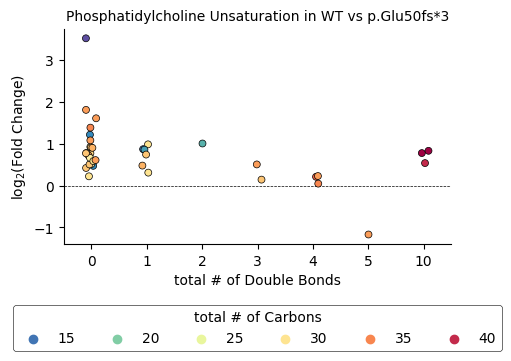

In [28]:
temp = stats[stats['class']=='PC'].copy()
plt.figure(figsize=(5, 2.8))
#
sp = sns.stripplot(data=temp, x='unsaturations', y='log2_fold_change', jitter=0.1, alpha = 1, hue = 'carbons', color = 'black', palette = 'Spectral_r', edgecolor='black', linewidth=0.5)

sp.spines['top'].set_visible(False)
sp.spines['right'].set_visible(False)

legend = plt.legend(bbox_to_anchor=(0.5, -0.25), loc='upper center', ncol=6, frameon=True, title='total # of Carbons')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(0.5)
plt.ylabel('log$_{2}$(Fold Change)', fontsize=10)
plt.xlabel('total # of Double Bonds', fontsize=10)
plt.title('Phosphatidylcholine Unsaturation in WT vs p.Glu50fs*3', fontsize=10)
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')

#plt.xlim(-1,9)
#plt.savefig('../../../paper/main_plots/pc_unsat.png', dpi=300, bbox_inches='tight')


In [20]:
# get # of perturbed lipids per subclass
stats['class'] = [x.split('(')[0] for x in stats.index]
subclass_dict = dict(zip(key['Key'], key['subclass']))
grouped = stats.groupby('class')['cat'].value_counts().unstack(fill_value=0)

# Compute total species per class.
grouped['Total'] = grouped.sum(axis=1)
grouped['down'] = 0
# Compute the total perturbed (up + down) and percentage.
grouped['Perturbed'] = grouped.get('up', 0) + grouped.get('down', 0)
grouped['% Perturbed'] = (grouped['Perturbed'] / grouped['Total'] * 100).round(1)
grouped['total'] = grouped['up'] + grouped['down']

# Create the summary table: absolute up, absolute down, and % perturbed.
table_df = grouped[['up', 'down', 'total', '% Perturbed']].rename(
    columns={'up': 'Up', 'down': 'Down', 'total': 'Total', 'empty': ''}
)

# subset table to only include classes with more than 0 total
table_df.sort_values(by='Total', ascending=False, inplace=True)
table_df = table_df.loc[table_df['Total']>0].copy()

# add subclass
table_df['Subclass'] = [subclass_dict[x] for x in table_df.index]

In [21]:
table_df

cat,Up,Down,Total,% Perturbed,Subclass
class,,,,,
TG,1,0,1,4.0,triglyceride
MLCL,1,0,1,16.7,Cardiolipin


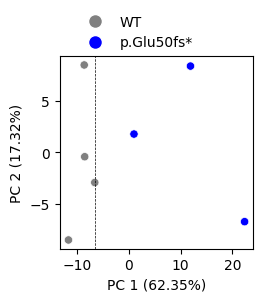

In [268]:
plot_pca(areas_24.iloc[:,(names_24=='E3 H2O') | (names_24=='G2 H2O')], names_24[(names_24=='E3 H2O') | (names_24=='G2 H2O')], palette={'E3 H2O':'gray', 'G2 H2O' : 'blue'}, draw_median=True)

# Add a custom legend based on marker type
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
        markerfacecolor='grey', markersize=10,linestyle='None', label='WT'),
    Line2D([0], [0], marker='o', markerfacecolor='blue',color='w',
        markersize=10, linestyle='None', label='p.Glu50fs*')
]
plt.legend(handles=legend_elements, title='', bbox_to_anchor=(.4, 1.28), loc='upper center', frameon=False)

/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/lcms_funcs.py:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.set_ylabel(df['class'][0], rotation=0, ha='right', va='center')
/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/lcms_funcs.py:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.set_ylabel(df['class'][0], rotation=0, ha='right', va='center')
/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/lcms_funcs.py:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, 

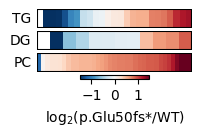

In [272]:
stats['class'] = [x.split('(')[0] for x in stats.index]
heatmap_data_list = [
    stats[stats['class'] == 'TG'],
    stats[stats['class'] == 'DG'],
    stats[stats['class'] == 'PC']
]
cbar = plot_lfcs(heatmap_data_list, 'log2_fold_change')
cbar.set_label('log$_{2}$(p.Glu50fs*/WT)')

In [273]:
stats['carbons'] = stats['name'].apply(count_carbons)
stats['unsaturations'] = stats['name'].apply(count_unsaturations)


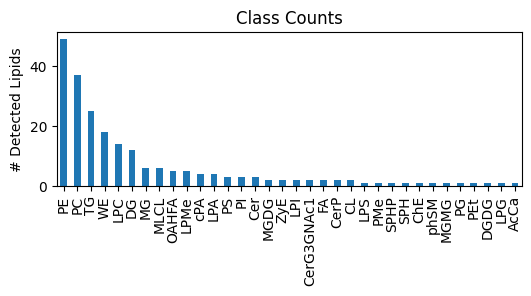

In [278]:
plt.figure(figsize=(6,2))
plot_class_counts(stats)

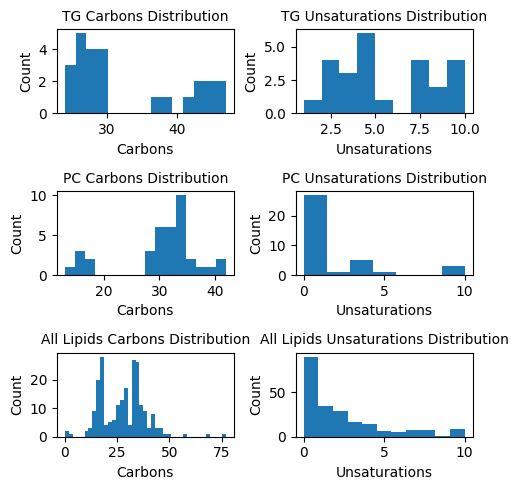

In [279]:
plot_carbon_distributions(stats)

In [280]:
# by group stats
groups = [x.split('(')[0] for x in areas_24.index]
by_grp = areas_24.groupby(groups).sum()
by_grp_stats = return_stats(by_grp, names_24,  'E3 H2O', 'G2 H2O')

by_grp_stats['score'] = -1*np.log10(by_grp_stats['p_value']) * np.sign(by_grp_stats['log2_fold_change'])
by_grp_stats.sort_values(by='p_value')

,t_stat,p_value,log2_fold_change,fdr_corrected_p_value,score
PS,6.003923,0.001874,0.668969,0.065574,2.727337
MLCL,5.408506,0.004597,0.828414,0.080448,2.337520
CerG3GNAc1,-6.048960,0.009057,-9.138079,0.105664,-2.043020
cPA,4.303549,0.045973,1.219964,0.256770,1.337501
FA,3.876858,0.048089,0.446604,0.256770,1.317957
MGMG,3.231716,0.063797,1.147633,0.256770,1.195197
PC,3.504048,0.064087,0.788518,0.256770,1.193233
PE,2.978038,0.064951,0.533209,0.256770,1.187417
MG,2.683830,0.067434,0.270594,0.256770,1.171118
PI,2.261242,0.073363,0.741822,0.256770,1.134524


In [296]:
# classify fatty acids in TGs
selected_rows_TG = areas_24[np.array(groups)=='TG']

carbon_counts_classified = np.array([classify_fatty_acid_length(np.round(count_carbons(x)/3)) for x in selected_rows_TG.index])

by_grp = selected_rows_TG.groupby(carbon_counts_classified).sum()
by_grp_stats = return_stats(by_grp, names_24,  'E3 H2O', 'G2 H2O')
by_grp_stats



,t_stat,p_value,log2_fold_change,fdr_corrected_p_value
LCFA,7.242039,0.002039,0.759061,0.004078
MCFA,-0.419149,0.698724,-0.098501,0.698724


In [297]:
np.unique(carbon_counts_classified, return_counts=True)

(array(['LCFA', 'MCFA'], dtype='<U4'), array([ 8, 17]))

In [298]:
# classify fatty acids in PCs
selected_rows_PC = areas_24[np.array(groups)=='PC']

carbon_counts_classified = np.array([classify_unsaturation(count_unsaturations(x)) for x in selected_rows_PC.index])

by_grp = selected_rows_PC.groupby(carbon_counts_classified).sum()
by_grp_stats = return_stats(by_grp, names_24,  'E3 H2O', 'G2 H2O')
by_grp_stats



,t_stat,p_value,log2_fold_change,fdr_corrected_p_value
MFA,5.617944,0.008220,0.829924,0.024660
PUFA,3.101697,0.058504,0.569749,0.068898
UFA,3.415376,0.068898,0.817972,0.068898


In [299]:
np.unique(carbon_counts_classified, return_counts=True)

(array(['MFA', 'PUFA', 'UFA'], dtype='<U4'), array([ 6, 10, 21]))

In [10]:
stats['carbons'] = stats['name'].apply(count_carbons)
stats['class'] = [x.split('(')[0] for x in stats.index]

<Axes: xlabel='carbons', ylabel='log2_fold_change'>

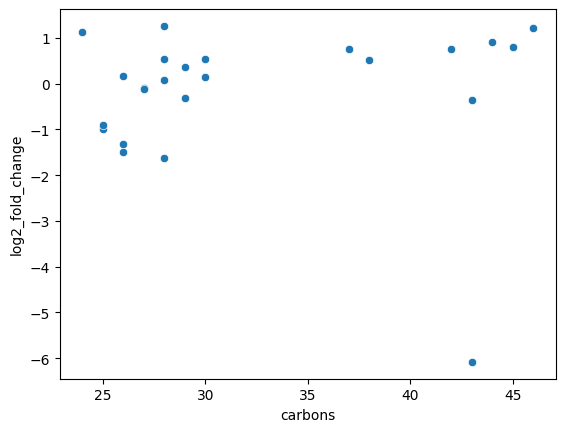

In [11]:
sns.scatterplot(data=stats[stats['class']=='TG'], x = 'carbons', y = 'log2_fold_change')